<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/regressao_linear_mortalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
indicadores = 'ANO', 'Codmun7', 'UF', 'Município', 'ESPVIDA', 'FECTOT', 'MORT1', 'SOBRE60', 'T_ENV', 'E_ANOSESTUDO', 'T_ANALF11A14', 'T_ANALF25M', 'T_ATRASO_0_BASICO', 'T_ATRASO_2_BASICO', 'T_FLPRE', 'T_FLSUPER', 'T_FREQSUPER1517', 'T_SUPER25M', 'T_MED25M', 'GINI', 'PIND', 'PINDCRI', 'PMPOB', 'PMPOBCRI', 'RDPC', 'CPR', 'EMP', 'P_AGRO', 'P_COM', 'P_CONSTR', 'P_EXTR', 'P_FORMAL', 'P_FUND', 'P_MED', 'P_SERV', 'P_SIUP', 'P_SUPER', 'T_DES2529', 'TRABCC', 'TRABPUB', 'TRABSC', 'T_AGUA', 'T_BANAGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'AGUA_ESGOTO', 'PAREDE', 'T_CRIFUNDIN_TODOS', 'T_FORA4A5', 'T_FORA6A14', 'T_FUNDIN_TODOS', 'T_FUNDIN_TODOS_MMEIO', 'T_FUNDIN18MINF', 'T_M10A14CF', 'T_M15A17CF', 'T_MULCHEFEFIF014', 'T_NESTUDA_NTRAB_MMEIO', 'T_OCUPDESLOC_1', 'T_RMAXIDOSO', 'T_SLUZ', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R' 
idhm = pd.read_excel('https://github.com/mirianbatista/idhm-pb/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', sheet_name=1, usecols = indicadores, dtype = {'UF': str, 'Codmun7':str}) 
#idhmpb = idhm.groupby(idhm['UF']).get_group('25').loc[(idhm['ANO'] == 2010)] 

In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
cols = 'city','city_ibge_code','date','estimated_population_2019','last_available_death_rate'
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, usecols=cols, parse_dates=["date"], dtype={"city_ibge_code": str})
covid = covid[covid.date == max(covid.date)]
covid

,city,city_ibge_code,date,estimated_population_2019,last_available_death_rate
8560,Acrelândia,1200013,2021-05-02,15256.0,0.0180
8561,Assis Brasil,1200054,2021-05-02,7417.0,0.0138
8562,Brasiléia,1200104,2021-05-02,26278.0,0.0142
8563,Bujari,1200138,2021-05-02,10266.0,0.0122
8564,Capixaba,1200179,2021-05-02,11733.0,0.0264
...,...,...,...,...,...
2005979,Tupirama,1721257,2021-05-02,1891.0,0.0144
2005980,Tupiratins,1721307,2021-05-02,2671.0,0.0156
2005981,Wanderlândia,1722081,2021-05-02,11683.0,0.0140
2005982,Xambioá,1722107,2021-05-02,11540.0,0.0125


In [ ]:
idhmcovid = pd.merge(idhm, covid, left_on="Codmun7", right_on="city_ibge_code", how="left") 
idhmcovid = idhmcovid.loc[(idhmcovid['estimated_population_2019'] > 100000) & (idhmcovid['ANO'] == 2010)].dropna()
idhmcovid.head()

,ANO,UF,Codmun7,Município,ESPVIDA,FECTOT,MORT1,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_2_BASICO,T_FLPRE,T_FLSUPER,T_FREQSUPER1517,T_MED25M,T_SUPER25M,GINI,PIND,PINDCRI,PMPOB,PMPOBCRI,RDPC,CPR,EMP,P_AGRO,P_COM,P_CONSTR,P_EXTR,P_FORMAL,P_FUND,P_MED,P_SERV,P_SIUP,P_SUPER,T_DES2529,TRABCC,TRABPUB,TRABSC,T_AGUA,T_BANAGUA,T_DENS,T_LIXO,T_LUZ,AGUA_ESGOTO,PAREDE,T_CRIFUNDIN_TODOS,T_FORA4A5,T_FORA6A14,T_FUNDIN_TODOS,T_FUNDIN_TODOS_MMEIO,T_FUNDIN18MINF,T_M10A14CF,T_M15A17CF,T_MULCHEFEFIF014,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,T_RMAXIDOSO,T_SLUZ,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_death_rate
11131,2010,11,1100023,ARIQUEMES,73.36,1.91,19.20,87.69,4.36,9.18,1.55,10.48,58.43,19.35,40.96,12.91,0.18,31.45,8.13,0.53,4.36,6.65,11.54,18.76,689.95,27.66,2.30,14.97,17.99,8.68,3.32,52.81,57.26,39.76,40.06,0.77,9.29,5.85,41.15,6.30,19.21,98.54,85.35,27.15,96.72,98.58,11.40,5.62,29.58,44.66,2.79,26.59,12.27,37.81,0.00,9.10,18.07,9.67,0.16,1.40,1.42,0.702,0.600,0.806,0.716,Ariquemes,1100023,2021-05-02,107863.0,0.0215
11141,2010,11,1100122,JI-PARANÁ,73.60,2.26,16.20,87.67,5.05,9.95,1.35,10.18,64.76,16.43,42.60,12.65,1.22,34.01,8.73,0.53,2.67,4.34,8.56,14.72,743.35,22.12,2.38,12.17,22.98,8.49,0.19,59.07,59.71,42.09,43.14,0.68,9.88,6.54,45.57,7.09,17.60,97.81,89.31,23.30,95.36,99.35,5.87,3.48,29.43,42.81,3.44,25.07,11.28,35.01,0.25,5.00,15.55,6.73,0.41,2.12,0.65,0.714,0.617,0.810,0.728,Ji-Paraná,1100122,2021-05-02,128969.0,0.0282
11146,2010,11,1100205,PORTO VELHO,74.14,2.13,15.52,88.56,3.52,8.99,1.85,6.62,56.08,22.43,43.16,15.84,1.48,43.12,12.21,0.56,2.64,4.30,7.95,13.61,929.19,21.60,1.20,6.27,15.38,12.82,0.54,65.48,66.77,49.95,49.35,1.84,13.47,6.39,50.22,11.07,14.04,92.87,72.14,36.73,95.67,98.20,17.76,3.41,23.82,32.74,5.48,19.05,7.93,26.48,1.05,8.04,17.06,6.99,0.76,0.75,1.80,0.736,0.638,0.819,0.764,Porto Velho,1100205,2021-05-02,529544.0,0.0300
11196,2010,12,1200401,RIO BRANCO,72.85,2.06,20.03,86.48,4.31,9.72,2.48,11.76,66.87,14.45,51.05,15.18,1.70,41.33,12.93,0.59,4.85,7.45,14.38,22.92,744.67,19.66,1.33,5.13,17.15,9.21,0.09,59.16,66.47,49.47,55.38,1.08,14.97,10.48,48.32,7.20,21.16,94.09,62.10,39.42,97.38,99.34,18.43,5.52,24.68,27.62,4.92,19.97,11.53,30.15,0.85,9.55,23.31,12.36,0.75,1.64,0.66,0.727,0.661,0.798,0.729,Rio Branco,1200401,2021-05-02,407319.0,0.0271
11232,2010,13,1301902,ITACOATIARA,73.66,2.84,15.31,87.71,5.03,8.76,5.66,11.96,53.75,25.49,25.48,6.75,1.38,28.55,5.88,0.59,17.45,23.24,36.60,47.38,373.71,31.61,0.53,28.31,16.30,6.70,0.00,32.14,51.63,34.41,36.85,0.79,6.96,9.34,22.12,6.35,26.83,78.88,62.11,59.14,97.62,92.63,24.77,8.24,33.31,35.39,4.93,29.28,21.70,48.84,1.05,14.01,35.04,17.93,1.08,3.78,7.37,0.644,0.534,0.811,0.618,Itacoatiara,1301902,2021-05-02,101337.0,0.0357


In [ ]:
correlacao_positiva = idhmcovid.corr().loc['last_available_death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
correlacao_positiva.drop(correlacao_positiva.loc[(correlacao_positiva['indicador'] == "last_available_death_rate")].index, inplace=True)
correlacao_positiva

,indicador,last_available_death_rate
1,T_OCUPDESLOC_1,0.439622
2,T_DES2529,0.332376
3,T_DENS,0.306719
4,P_SERV,0.223824
5,T_NESTUDA_NTRAB_MMEIO,0.171675
6,MORT1,0.132726
7,P_CONSTR,0.127965
8,estimated_population_2019,0.127116
9,TRABSC,0.114223


In [ ]:
corr_posit = correlacao_positiva.indicador.to_list()
corr_posit

['T_OCUPDESLOC_1',
 'T_DES2529',
 'T_DENS',
 'P_SERV',
 'T_NESTUDA_NTRAB_MMEIO',
 'MORT1',
 'P_CONSTR',
 'estimated_population_2019',
 'TRABSC']

In [ ]:
corr_positiva = idhmcovid[idhmcovid.columns.intersection(corr_posit)]
corr_positiva

,MORT1,P_CONSTR,P_SERV,T_DES2529,TRABSC,T_DENS,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,estimated_population_2019
11131,19.20,8.68,40.06,5.85,19.21,27.15,9.67,0.16,107863.0
11141,16.20,8.49,43.14,6.54,17.60,23.30,6.73,0.41,128969.0
11146,15.52,12.82,49.35,6.39,14.04,36.73,6.99,0.76,529544.0
11196,20.03,9.21,55.38,10.48,21.16,39.42,12.36,0.75,407319.0
11232,15.31,6.70,36.85,9.34,26.83,59.14,17.93,1.08,101337.0
...,...,...,...,...,...,...,...,...,...
16645,11.68,7.99,40.57,5.45,18.62,20.25,5.87,0.24,235647.0
16671,13.70,13.51,48.29,7.01,22.36,29.94,8.75,3.66,115371.0
16680,11.78,10.39,43.11,4.82,23.41,22.12,9.93,2.23,127599.0
16688,14.83,11.45,56.14,7.45,17.22,28.09,7.72,2.36,168468.0


In [ ]:
mortalidade = idhmcovid.last_available_death_rate

In [ ]:
xtrain_corr_positiva, xtest_corr_positiva, ytrain_corr_positiva, ytest_corr_positiva = train_test_split(corr_positiva, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_positiva = LinearRegression()
linreg_corr_positiva.fit(xtrain_corr_positiva, ytrain_corr_positiva)
print('linear model coeff (w): {}'
.format(linreg_corr_positiva.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_positiva.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_positiva.score(xtrain_corr_positiva, ytrain_corr_positiva)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_positiva.score(xtest_corr_positiva, ytest_corr_positiva)))

linear model coeff (w): [ 1.13704361e-03 -1.40966882e-03  4.77006302e-04  1.61701593e-03
 -5.52216629e-05  2.59340302e-04 -1.17982320e-03  5.68759257e-03
  2.94573387e-11]
linear model intercept (b): -0.011
R-squared score (training): 0.297
R-squared score (test): -0.050


In [ ]:
ipred_corr_positiva = linreg_corr_positiva.predict(xtest_corr_positiva)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_positiva, ipred_corr_positiva))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_positiva, ipred_corr_positiva))

Mean squared error: 0.00
Coefficient of determination: -0.05


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_positiva, y=ipred_corr_positiva, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação positiva de mortalidade de COVID-19")
fig.show()

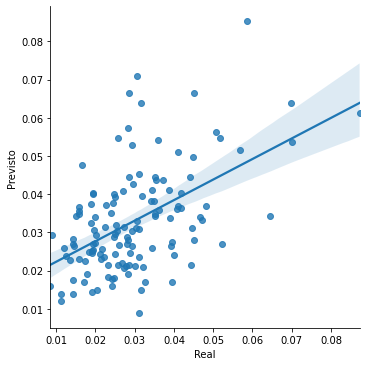

In [ ]:
df_corr_positiva = pd.DataFrame ({'Real': ytest_corr_positiva, 'Previsto': ipred_corr_positiva}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_positiva);

In [ ]:
correlacao_negativa = idhmcovid.corr().loc['last_available_death_rate'].sort_values().to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
corr_negat = correlacao_negativa.indicador.to_list()
corr_negativa = idhmcovid[idhmcovid.columns.intersection(corr_negat)]

In [ ]:
xtrain_corr_negativa, xtest_corr_negativa, ytrain_corr_negativa, ytest_corr_negativa = train_test_split(corr_negativa, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_negativa = LinearRegression()
linreg_corr_negativa.fit(xtrain_corr_negativa, ytrain_corr_negativa)
print('linear model coeff (w): {}'
.format(linreg_corr_negativa.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_negativa.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_negativa.score(xtrain_corr_negativa, ytrain_corr_negativa)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_negativa.score(xtest_corr_negativa, ytest_corr_negativa)))

linear model coeff (w): [-0.00046985 -0.00127385  0.0003551  -0.00211896 -0.00082247 -0.0045414
 -0.00170466 -0.00162927 -0.00172177  0.11861779]
linear model intercept (b): 0.440
R-squared score (training): 0.412
R-squared score (test): -0.297


In [ ]:
ipred_corr_negativa = linreg_corr_negativa.predict(xtest_corr_negativa)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_negativa, ipred_corr_negativa))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_negativa, ipred_corr_negativa))

Mean squared error: 0.00
Coefficient of determination: -0.30


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_negativa, y=ipred_corr_negativa, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação negativa de mortalidade de COVID-19")
fig.show()

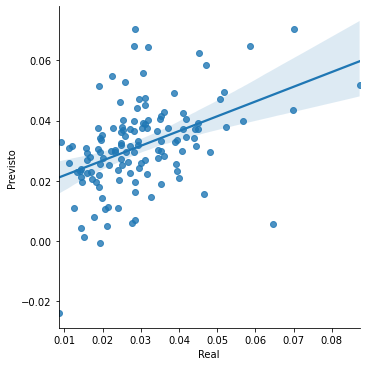

In [ ]:
df_corr_negativa = pd.DataFrame ({'Real': ytest_corr_negativa, 'Previsto': ipred_corr_negativa}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_negativa)

In [ ]:
corr_posit_negat = corr_posit + corr_negat
corr_pos_neg = idhmcovid[idhmcovid.columns.intersection(corr_posit_negat)]

In [ ]:
xtrain_corr_pos_neg, xtest_corr_pos_neg, ytrain_corr_pos_neg, ytest_corr_pos_neg = train_test_split(corr_pos_neg, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_pos_neg = LinearRegression()
linreg_corr_pos_neg.fit(xtrain_corr_pos_neg, ytrain_corr_pos_neg)
print('linear model coeff (w): {}'
.format(linreg_corr_pos_neg.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_pos_neg.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_pos_neg.score(xtrain_corr_pos_neg, ytrain_corr_pos_neg)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_pos_neg.score(xtest_corr_pos_neg, ytest_corr_pos_neg)))

linear model coeff (w): [ 7.51448454e-04  9.03577133e-05 -1.58465776e-03  7.45525267e-05
 -1.26405552e-03 -2.87878960e-03 -8.33498716e-04 -1.24243305e-03
 -3.63186798e-03  6.18326989e-04  1.47665244e-03  4.96451211e-04
 -1.62864731e-03  7.42298058e-05 -2.22032980e-03 -5.28253156e-04
  2.37108308e-03  2.74717765e-01 -4.75133690e-10]
linear model intercept (b): 0.304
R-squared score (training): 0.553
R-squared score (test): -0.521


In [ ]:
pred_corr_pos_neg = linreg_corr_pos_neg.predict(xtest_corr_pos_neg)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_pos_neg, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_pos_neg, pred_corr_pos_neg))

Mean squared error: 0.00
Coefficient of determination: -0.52


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_pos_neg, y=pred_corr_pos_neg, mode='markers')) 
fig.update_layout(title="Valores reais e previstos das 20 maiores correlações de mortalidade de COVID-19")
fig.show()

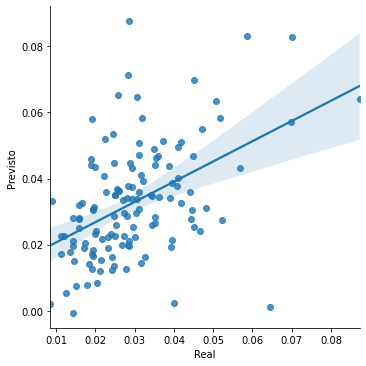

In [ ]:
df_corr_pos_neg = pd.DataFrame ({'Real': ytest_corr_pos_neg, 'Previsto': pred_corr_pos_neg}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_pos_neg)